In [1]:
import pandas
import matplotlib
import seaborn

from functools import partial

import dateutil
import datetime
import itertools
import os

from faker import Faker
from statsmodels.duration.survfunc import SurvfuncRight
from scipy.stats import mannwhitneyu

In [2]:
%matplotlib inline

# Use to restrict x-axis when displaying time-related data
DATE_RANGE = (pandas.to_datetime('2016-09'), pandas.to_datetime('2019-06-01'))

FIG_SIZE = (7, 2.5)
PALETTE = seaborn.color_palette()
matplotlib.rcParams['figure.figsize'] = FIG_SIZE

def savefig(fig, name):
    fig.savefig(
        os.path.join('..', 'figures', '{}.pdf'.format(name)),
        bbox_inches='tight'
    )

# Model definition

We use survival analysis on the recent past activity of each contributor/project to estimate its next inactivity period duration. 
As the model is based on survival analyses, it is a probabilistic model, i.e., it provides a probability distribution. 

## Survival analysis

In [3]:
def dates_to_duration(dates, *, window_size=20, current=None):
    """
    Convert a list of datetimes into a list of durations (between consecutive dates).
    Datetimes could be provided as unordered strings representing dates. 
    The resulting list is composed 'window_size' durations between consecutive dates d such that
    d <= current.
    """
    if current is None:
        current = datetime.date.today()
    else:
        current = dateutil.parser.parse(current).date()
    
    kept = set()
    # threshold = current - dateutil.relativedelta.relativedelta(days=window_size)
    for date in dates:
        date = dateutil.parser.parse(date).date()
        if date <= current:
            kept.add(date)
        # No "else", because we don't know if "dates" is sorted
    
    kept = sorted(kept)[-window_size - 1:]  # -1 because intervals vs. bounds
    durations = []
    for first, second in zip(kept[:-1], kept[1:]):
        duration = (second - first).days
        durations.append(duration)
    
    return durations

In [4]:
def model(durations, probabilities=[0.5, 0.75, 0.9], *, return_surv=False):
    """
    Return the durations corresponding to given probabilities, using survival analysis.
    """
    surv = SurvfuncRight(durations, [1] * len(durations))
    if return_surv:
        return surv
    else:
        return [surv.quantile(p) for p in probabilities]

# Model validation

## Prepare dataset

The dataset that will be used to assess whether our model is effective or not is based on the commit information of Cargo packages.

In [5]:
df_raw = (
    pandas.read_csv('../data/cargo.csv.gz')
    .assign(date=lambda d: pandas.to_datetime(d['date']))
    .dropna(subset=['truth'])
)

In [6]:
df_raw.head()

,author,author_name,project,date,commits,duration,truth
0,aepsil0n,Eduard Bopp,aepsil0n/acacia,2014-11-28,2,NaN,1 days 00:00:00
1,aepsil0n,Eduard Bopp,aepsil0n/acacia,2014-11-29,4,1 days 00:00:00,3 days 00:00:00
2,aepsil0n,Eduard Bopp,aepsil0n/acacia,2014-12-02,7,3 days 00:00:00,1 days 00:00:00
3,aepsil0n,Eduard Bopp,aepsil0n/acacia,2014-12-03,1,1 days 00:00:00,1 days 00:00:00
4,aepsil0n,Eduard Bopp,aepsil0n/acacia,2014-12-04,20,1 days 00:00:00,6 days 00:00:00


In [7]:
# Remove unknown authors (should be empty)
df = df_raw.dropna(subset=['author'])
print('Authors na:', len(df_raw) - len(df))

# Remove first "day of activity" of each contributor, as it does
# not contain useful information for the model (because it has no "previous delay").
s = len(df.drop_duplicates(['project', 'author']))
print('Pairs in raw dataset:', s)
df = df.dropna(subset=['duration'])
print('Dropped pairs:', s - len(df.drop_duplicates(['project', 'author'])))

# We arbitrarilly define that "0" means "no delay". This does not change
# the results, that's just an internal convention.
df = df.assign(duration=lambda d: pandas.to_timedelta(d['duration']).dt.days - 1)
df = df.assign(truth=lambda d: pandas.to_timedelta(d['truth']).dt.days - 1)

Authors na: 0
Pairs in raw dataset: 24315
Dropped pairs: 6975


### Dataset overview

Add data about repositories (extracted from libraries.io dataset):

In [8]:
df_repo = pandas.read_csv('../data/repositories.csv.gz')

In [9]:
df_repo.head()

,project,url,releases,created,size,stars,forks
0,rust-lang/rust,https://github.com/rust-lang/rust,318,2010-06-16 20:39:03 UTC,409867.0,32655.0,5399.0
1,google/xi-editor,https://github.com/google/xi-editor,3,2016-04-26 23:03:23 UTC,6545.0,15193.0,559.0
2,servo/servo,https://github.com/servo/servo,42,2012-02-08 19:07:25 UTC,766421.0,13041.0,2028.0
3,BurntSushi/ripgrep,https://github.com/BurntSushi/ripgrep,3,2016-03-11 02:02:33 UTC,2780.0,11929.0,488.0
4,sharkdp/fd,https://github.com/sharkdp/fd,12,2017-05-09 21:27:10 UTC,604.0,7120.0,183.0


In [10]:
df_projects = (
    df_raw
    # Keep only considered projects
    [lambda d: d['project'].isin(df['project'].unique())]
    .assign(first_date=lambda d: d['date'])
    .assign(last_date=lambda d: d['date'])
    .assign(days=lambda d: d['date'])
    .groupby('project', sort=False)
    .agg({
        'first_date': 'min',
        'last_date': 'max',
        'author': lambda s: s.nunique(),
        'days': lambda s: s.nunique(),
        'commits': 'sum',
    })
    .rename(columns={'author': 'contributors'})
    .assign(longevity=lambda d: (d['last_date'] - d['first_date']).dt.days)
    .merge(df_repo, how='left', left_on='project', right_on='project')
)

In [11]:
df_projects[['longevity', 'contributors', 'commits', 'days', 'size', 'stars', 'forks']].describe(percentiles=[.25, .5, .75, .90]).T

,count,mean,std,min,25%,50%,75%,90%,max
longevity,7528.0,485.802205,500.984215,1.0,61.0,349.5,761.25,1185.0,6887.0
contributors,7528.0,3.125797,19.396651,1.0,1.0,1.0,2.00,5.0,1413.0
commits,7528.0,146.585547,1229.925692,2.0,16.0,39.0,100.00,257.0,89179.0
days,7528.0,37.932917,103.659249,2.0,5.0,12.0,32.00,82.0,3214.0
size,6927.0,1767.720803,13580.526795,0.0,24.0,102.0,696.00,2996.0,766421.0
stars,6927.0,62.141908,551.827418,0.0,1.0,3.0,15.00,74.0,32655.0
forks,6927.0,8.120543,77.049180,0.0,0.0,1.0,3.00,13.0,5399.0


In [12]:
df_authors = (
    df_raw
    # Keep only considered authors
    [lambda d: d['author'].isin(df['author'].unique())]
    .assign(first_date=lambda d: d['date'])
    .assign(last_date=lambda d: d['date'])
    .assign(days=lambda d: d['date'])
    .groupby('author', sort=False)
    .agg({
        'first_date': 'min',
        'last_date': 'max',
        'project': lambda s: s.nunique(),
        'days': lambda s: s.nunique(),
        'commits': 'sum',
    })
    .rename(columns={'project': 'projects'})
    .assign(longevity=lambda d: (d['last_date'] - d['first_date']).dt.days)
)

In [13]:
df_authors[['longevity', 'projects', 'commits', 'days']].describe(percentiles=[.25, .5, .75, .90]).T

,count,mean,std,min,25%,50%,75%,90%,max
longevity,5947.0,492.846645,555.934354,1.0,38.0,300.0,789.0,1291.0,6032.0
projects,5947.0,3.712292,7.106237,1.0,1.0,2.0,3.0,8.0,158.0
commits,5947.0,185.508492,719.624930,2.0,8.0,28.0,115.0,395.4,23422.0
days,5947.0,48.463763,119.477164,2.0,4.0,11.0,39.0,122.0,2290.0


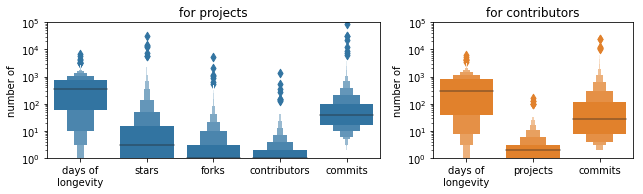

In [17]:
fig, axes = matplotlib.pyplot.subplots(ncols=2, gridspec_kw={'width_ratios': [5, 3]})
fig.set_size_inches(FIG_SIZE[0] * 1.5, FIG_SIZE[1])

seaborn.boxenplot(
    x='variable', 
    y='value',
    data=(
        df_projects
        .melt(id_vars=['project'], value_vars=['longevity', 'stars', 'forks', 'contributors', 'commits'])
        .replace({'longevity': 'days of\nlongevity'})
    ),
    color=PALETTE[0],
    ax=axes[0],
)

axes[0].set(
    title='for projects',
    xlabel='',
    ylabel='number of',
    yscale='log',
    ylim=(1, 10e4 + 1),
)

seaborn.boxenplot(
    x='variable', 
    y='value',
    data=(
        df_authors
        .melt(id_vars=['author'], value_vars=['longevity', 'projects', 'commits'])
        .replace({'longevity': 'days of\nlongevity'})
    ),
    color=PALETTE[1],
    ax=axes[1],
)

axes[1].set(
    title='for contributors',
    xlabel='',
    ylabel='number of',
    yscale='log',
    ylim=(1, 10e4 + 1),
)

savefig(fig, 'descr_dataset')

In [15]:
print('Final dataset')
print('Projects:', len(df.drop_duplicates('project')))
print('Authors:', len(df.drop_duplicates('author')))
print('Timelines:', len(df.drop_duplicates(['project', 'author'])))
# Days + pairs, because we removed the first day of activity
print('Days of activity:', len(df) + len(df.drop_duplicates(['project', 'author'])))

Final dataset
Projects: 7528
Authors: 5947
Timelines: 17340
Days of activity: 374622


### Data anonymization

In [16]:
fake = Faker()
fake.seed(12345)

In [17]:
aliases = {}
mapping = {}

for row in (
        df
        .drop_duplicates('author_name')
        # "author_name" is the "displayed name", while "author" is the github username
        [['author_name', 'author']]
        .dropna()
    ).itertuples():
    aliases[row.author] = fake.first_name()[0] + '. ' + fake.last_name()
    mapping[row.author_name.encode().decode('unicode_escape')] = aliases[row.author]

In [18]:
# Manual mapping for our specific example
# This manual mapping is helpful when the mapping.csv file is used with git in our example

mapping['bors-servo'] = 'bots (grouped)'
mapping['WPT Sync Bot'] = 'bots (grouped)'

mapping['Emilio Cobos Álvarez'] = mapping['Emilio Cobos Ã\x81lvarez']

mapping['Fernando Jiménez Moreno'] = mapping['Fernando Jimenez Moreno']
mapping['Fernando JimÃ©nez Moreno'] = mapping['Fernando Jimenez Moreno']

In [19]:
pandas.DataFrame(list(mapping.items()), columns=['source', 'target']).to_csv('../data/mapping.csv', index=False)

### Number of pairs/timelines w.r.t. window size

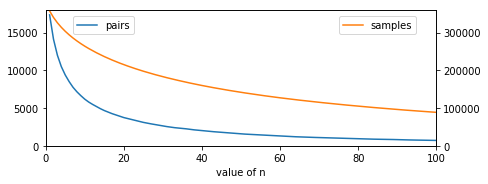

In [20]:
fig, ax = matplotlib.pyplot.subplots()
fig.set_size_inches(FIG_SIZE)

pairs = (
    df
    .groupby(['project', 'author'], sort=False)
    .agg({'date': 'count'})
    .rename(columns={'date': 'observations'})
    .assign(observations=lambda d: d['observations'] + 1)  # Because of dropped "truth=na"
    .assign(pairs=1)
    .groupby('observations', as_index=False)
    .sum()
)

data = []
for n in range(0, 200 + 1):
    p = pairs[pairs['observations'] >= n + 1].pairs.sum()
    t = (
        pairs
        [pairs['observations'] >= n + 1]
        .eval('(observations - @n) * pairs')
        .sum()
    )
    data.append((n, p, t))
    
temp = (
    pandas.DataFrame(columns=['n', 'pairs', 'samples'], data=data)
    .set_index('n')
)

temp[['pairs']].loc[1:].plot(color=PALETTE[0], ax=ax)
ax.legend(loc=(0.07, 0.82))
ax.set(
    xlabel='value of n',
    xlim=(0, 100),
    ylim=(0, 18000)
)

ax2 = ax.twinx()
temp[['samples']].loc[1:].plot(color=PALETTE[1], ax=ax2)
ax2.legend(loc=(0.75, 0.82))
ax2.set(
    ylim=(0, 360000),
)


savefig(fig, 'dataset_size')

In [21]:
temp.loc[[0, 1, 2, 10, 20, 30, 50, 100, 200]]

,pairs,samples
n,,
0,17340,374622
1,17340,357282
2,14109,339942
10,6177,263940
20,3738,214993
30,2628,183072
50,1582,141679
100,698,88644
200,254,45742


## Model computation

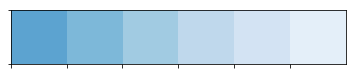

In [22]:
WINDOW_SIZE = 20
PROBABILITIES = [p / 100 for p in range(10, 100, 10)]
SHOWN_PROBABILITIES = [0.5, 0.6, 0.7, 0.8, 0.9]

PALETTE_GRADIENT = seaborn.color_palette('Blues_r', n_colors=len(SHOWN_PROBABILITIES) + 5)[4:]
seaborn.palplot(PALETTE_GRADIENT)

markers = ['o', 'v', 's', 'd']

In [23]:
def rolling_window(seq, n=2):
    """
    Returns a sliding window (of width n) over data from the iterable
    e.g.: s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...
    """
    it = iter(seq)
    result = tuple(itertools.islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [24]:
def rolling_computation(df, *, window_size, probabilities):
    data = []

    for ix, group in df.groupby(['project', 'author'], sort=False):
        for window in rolling_window(group.itertuples(), window_size):
            if len(window) >= window_size:
                probs = model([r.duration for r in window], probabilities)
                data.append(
                    ix + (window[-1].date,) + tuple(probs) + (window[-1].truth,)
                )
    return (
        pandas.DataFrame(data=data, columns=['project', 'author', 'date'] + probabilities + ['truth'])
        .set_index(['project', 'author', 'date'])
        .dropna()
    )

In [25]:
df_model = rolling_computation(df, window_size=WINDOW_SIZE, probabilities=PROBABILITIES)

## Examples

### Survival analysis at specific points in time

This example shows the predicted durations for a set of examples. 

/home/alexandre/.local/share/virtualenvs/secos-activity/lib/python3.5/site-packages/ipykernel_launcher.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  if sys.path[0] == '':


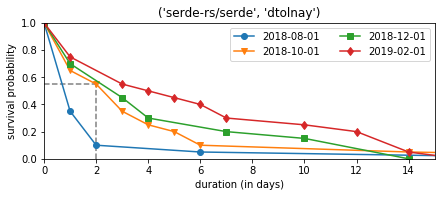

In [26]:
examples = [
    ('serde-rs/serde', 'dtolnay', ['2018-08-01', '2018-10-01', '2018-12-01', '2019-02-01']),
]

fig, axes = matplotlib.pyplot.subplots(nrows=len(examples), squeeze=False, sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE[0], FIG_SIZE[1])

for i, (project, author, dates) in enumerate(examples):
    ax = axes[i][0]
    
    for j, date in enumerate(dates):
        durations = dates_to_duration(df_model.loc[(project, author)].index.astype(str), current=date, window_size=WINDOW_SIZE)
        if len(durations) < WINDOW_SIZE:
            print('{} has not enough items ({} vs. {})'.format(date, len(durations), WINDOW_SIZE))
            
        surv = model(durations, return_surv=True)
        ax.plot([0] + list(surv.surv_times), [1] + list(surv.surv_prob), marker=markers[j], label=date, color=PALETTE[j])
        
    ax.legend(ncol=2)
    ax.set(
        title=(project, author), 
        xlabel='duration (in days)',
        xlim=(0, 15),
        ylabel='survival probability',
        ylim=(0, 1),
    )    
    
ax.hlines(0.55, 0, 2, colors='gray', linestyles='dashed', alpha=1)
ax.vlines(2, 0, 0.55, colors='gray', linestyles='dashed', alpha=1)
    
savefig(fig, 'surv_analysis')

### Rolling evaluation for specific projects/authors

This example shows a rolling prediction (i.e. predictions are made for all points in time). 
The bands correspond to different probabilities. The crosses are the actual observations.

/home/alexandre/.local/share/virtualenvs/secos-activity/lib/python3.5/site-packages/ipykernel_launcher.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  del sys.path[0]


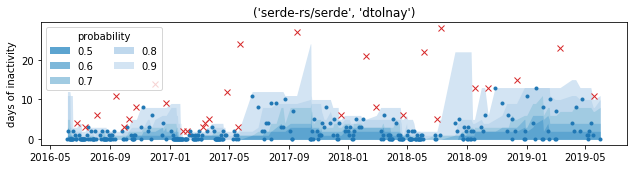

In [27]:
examples = [
    ('serde-rs/serde', 'dtolnay'),
    #('servo/servo', 'emilio'),
    #('servo/servo', 'hiikezoe'),
]

fig, axes = matplotlib.pyplot.subplots(nrows=len(examples), sharex=True, sharey=False, squeeze=False, gridspec_kw={'hspace': 0.2})
fig.set_size_inches(FIG_SIZE[0] * 1.5, FIG_SIZE[1] * len(examples))

for i, example in enumerate(examples):
    ax = axes[0][i]
    
    temp = df_model.loc[example]
    
    #ax.fill_between(temp.index, temp[SHOWN_PROBABILITIES[0]], color='b', alpha=0.1, linewidth=0)
    #for i, (p1, p2) in enumerate(zip(SHOWN_PROBABILITIES[:-1], SHOWN_PROBABILITIES[1:])):
    #    ax.fill_between(temp.index, temp[p1], temp[p2], color='b', alpha=(i + 2) * 0.1, linewidth=0)
    for i, p in reversed([e for e in enumerate(SHOWN_PROBABILITIES)]):
        ax.fill_between(temp.index, temp[p], color=PALETTE_GRADIENT[i], linewidth=0)
        
    threshold = SHOWN_PROBABILITIES[-1]
    temp[lambda d: d['truth'] <= d[threshold]]['truth'].plot(style='.', marker='.', color=PALETTE[0], ax=ax)
    temp[lambda d: d['truth'] > d[threshold]]['truth'].plot(style='.', marker='x', color=PALETTE[3], ax=ax)
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
        tick.set_horizontalalignment('center')
    
    ax.set(
        title=example,
        xlabel='',
        ylabel='days of inactivity',
    )
    
    ax.legend(
        [matplotlib.patches.Patch(facecolor=PALETTE_GRADIENT[i]) for i,p in enumerate(SHOWN_PROBABILITIES)],
        SHOWN_PROBABILITIES,
        title='probability',
        loc='upper left',
        ncol=2,
    )
    
savefig(fig, 'rolling_evaluation')

In [39]:
temp.apply(lambda s: s >= s['truth'], axis=1).sum() / 341

0.1      0.498534
0.2      0.510264
0.3      0.536657
0.4      0.577713
0.5      0.604106
0.6      0.662757
0.7      0.730205
0.8      0.826979
0.9      0.912023
truth    1.000000
dtype: float64

## Model evaluation

Probabilistic models are not easy to evaluate. There are ways to compare different probabilistic models but none of them can be used to provide a "global absolute" score (e.g. between 0 and 1) that can be used to assess its accuracy. So we ran different analyses and made several plots to show how "good" our model is.

In [26]:
def evaluate_rolling_model(df, kind='upper'):
    op = {
        'strict lower': lambda a,b: a < b,
        'strict upper': lambda a,b: a > b,
        'lower': lambda a,b: a <= b,
        'upper': lambda a,b: a >= b,
        'exact': lambda a,b: a == b,
    }
    
    return (
        df
        .dropna()
        .pipe(lambda d:
            d.apply(lambda s: op[kind](s, d['truth']))
        )
        .drop(columns='truth')
        .pipe(lambda d: d.sum() / len(d))
        .to_frame(kind)
        .rename_axis('probability')
    )

### Predicted values

In [29]:
df_model.describe()

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,truth
count,214993.000000,214993.000000,214993.000000,214993.000000,214993.000000,214993.000000,214993.000000,214993.000000,214993.000000,214993.000000
mean,0.094850,0.271595,0.731982,1.378831,2.216854,3.541497,5.775714,10.583824,22.065960,9.206872
std,0.509308,0.899242,1.764027,2.742258,3.995254,5.908699,9.012660,15.895443,33.460421,34.623561
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,4.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,3.000000,5.000000,10.000000,1.000000
75%,0.000000,0.000000,1.000000,2.000000,2.000000,4.000000,6.000000,12.000000,26.000000,5.000000
max,19.000000,26.000000,43.000000,52.000000,67.000000,136.000000,178.000000,364.000000,676.000000,1702.000000


The following plot show the distribution of predicted values for each probability class. 
For comparison, it also includes the duration reached by the set of "actual values", w.r.t. to the quantiles of these observed values.

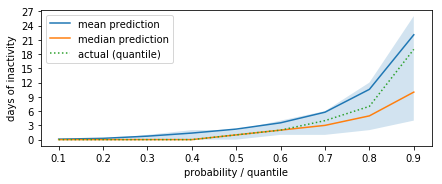

In [30]:
fig, ax = matplotlib.pyplot.subplots()

temp = df_model.describe().T.drop('truth')

temp[['mean', '50%']].plot(ax=ax)
ax.fill_between(PROBABILITIES, temp['25%'], temp['75%'], alpha=0.2)

ax.set(
    xlabel='probability / quantile',
    ylabel='days of inactivity',
)
ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

df_model[['truth']].quantile(PROBABILITIES).plot(ax=ax, style=':')

ax.legend(['mean prediction', 'median prediction', 'actual (quantile)'], loc='upper left')

savefig(fig, 'probability_quantile')

### Over, under and exact estimations

Our model provides predictions associated with different probabilities. Because these probabilities are somehow "cumulative" (because "durations" are!), the predicted durations are expected to represent upper bounds on the number of days of inactivity. The following plot shows the proportion of case (based on actual observations) where the predicted duration, for each probability class, is an exact estimation (not the purpose of the model), an underestimation (not the purpose of the model) or an overestimation. 

We show that our model is mostly "efficient" for larger probabilities. Starting from around 0.5, the sum of "exact" and "overestimation" (both form an "upper bound") reaches around 60% of the actual observations. We will see in another plot how this sum behaves w.r.t. the probabilities.

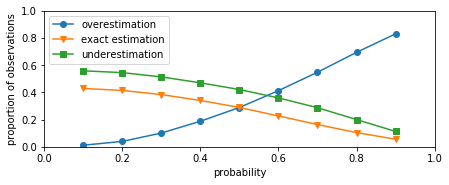

In [31]:
fig, ax = matplotlib.pyplot.subplots()

_ = pandas.concat([
    evaluate_rolling_model(df_model, 'strict lower'),
    evaluate_rolling_model(df_model, 'strict upper'),
    evaluate_rolling_model(df_model, 'exact')
], axis=1).rename(columns={
    'strict lower': 'underestimation',
    'strict upper': 'overestimation',
    'exact': 'exact estimation',
})[['overestimation', 'exact estimation', 'underestimation']]

for i, column in enumerate(_.columns):
    _[column].plot(marker=markers[i], style='-', ax=ax, label=column)

ax.legend()

ax.set(
    xlabel='probability',
    ylabel='proportion of observations',
    xlim=(0, 1),
    ylim=(0, 1),
)

savefig(fig, 'over_underestimation')

### Positive predictions w.r.t. probability and predicted value

It's quite easy to create a model that will lead to similar results (p% of overestimations/upper bounds for probability p). It suffices to predict p% of the time a veeeery large value, and 100-p% a very small value. To show that our model is not behaving like that, and that the predicted bounds are "quite tight", we count the proportion of "positive" observations (i.e. observations that are lower or equal to the predicted upper bound), w.r.t. probabilities **and** predicted durations. 

We observe that the predictions made for lower probabilities are not very accurate (most of them are lower than the actual observations), but the predictions made for higher probabilities are quite accurate, even when the predicted value is low (which confirms that our model will not lead to "huge overestimation".

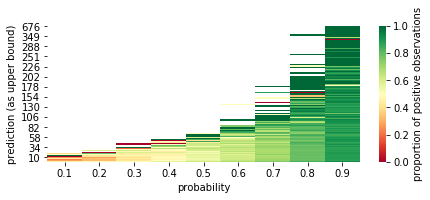

In [32]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.heatmap(
    vmin=0,
    vmax=1,
    data=pandas.concat([
            df_model
            .assign(correct=lambda d: d[p] >= d['truth'])
            .groupby(p)
            .agg({'correct': lambda s: s.sum() / len(s)})
            .rename(columns={'correct': p})
            .rename_axis('prediction')
        for p in PROBABILITIES], axis=1
    ).sort_index(ascending=False),
    cbar_kws={'label': 'proportion of positive observations'},
    cmap='RdYlGn',
    ax=ax
)

ax.set(
    xlabel='probability',
    ylabel='prediction (as upper bound)',
)

savefig(fig, 'prediction_concordance')

### Q-Q Plot (~ calibration plot / reliability diagram)

From Wikipedia: Calibration can be assessed using a calibration plot (also called a reliability diagram). A calibration plot shows the proportion of items in each class for bands of predicted probability or score (such as a distorted probability distribution or the "signed distance to the hyperplane" in a support vector machine). Deviations from the identity function indicate a poorly-calibrated classifier for which the predicted probabilities or scores can not be used as probabilities. In this case one can use a method to turn these scores into properly calibrated class membership probabilities. (https://en.wikipedia.org/wiki/Probabilistic_classification#Probability_calibration)

This analysis merely corresponds to the behaviour of aforementioned "sum of exact + overestimation". A perfectly concordant model will have e.g. 90% of the observations lower than the value predicted with 90% probability (and you can replace "90" by any other value 0 < x < 100). Here, we observe that our model is not that good but not that bad, in the sense that while it provides "too high" predictions for lower probabilities, but slightly "too low" predictions for high probabilities. It also shows that the model is quite accurate between probabilities 0.5 and 0.9.

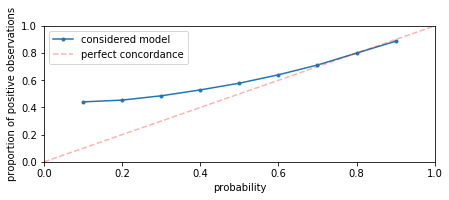

In [33]:
fig, ax = matplotlib.pyplot.subplots()

(
    evaluate_rolling_model(df_model)
    .plot(marker='.', ax=ax)
)

ax.set(
    xlim=(0, 1),
    xlabel='probability',
    ylim=(0, 1),
    ylabel='proportion of positive observations',
)

ax.plot([0, 1], [0, 1], linestyle='dashed', color='r', alpha=0.3)
ax.legend(['considered model', 'perfect concordance'])

savefig(fig, 'qqplot')

In [34]:
evaluate_rolling_model(df_model)

,upper
probability,
0.1,0.440777
0.2,0.454131
0.3,0.485681
0.4,0.528989
0.5,0.578475
0.6,0.640216
0.7,0.712358
0.8,0.799812
0.9,0.887010


### Errors wrt. predicted duration

Here we looked at the difference between the predicted values and the actual observations. The true meaning of this difference ("the error") is difficult to estimate, because we are dealing with a (non-continuous) probabilistic model (hence, a "predicted value" cannot be directly compared to the observed value, as there is a probability associated with the prediction). There are approaches to compute a score based on this, but this score is not meaningful except when used to compare different models.

Here, we observe that our model is "better" for higher probabilities (the error, both in absolute or relative values, is lower). However, we also observe that relative errors are quite high. The reason is that we're dealing with "low values". Remember from the quantiles of actual values that more than 50% of them are <=1. If prediction is 2 where actual value is 1, this leads to a relative error of 100%.

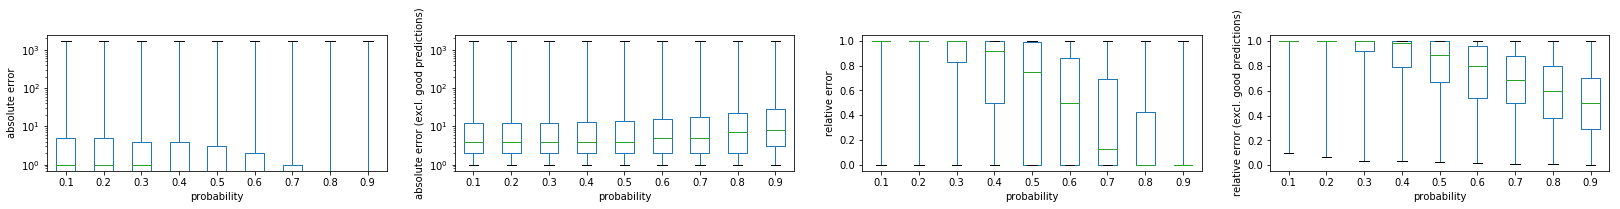

In [35]:
KIND = [
    ('absolute error', lambda d: d.apply(lambda s: (d['truth'] - s).clip(0))),
    ('absolute error (excl. good predictions)', lambda d: d.apply(lambda s: (d['truth'] - s).clip(0).replace(0, pandas.np.nan))),
    ('relative error', lambda d: d.apply(lambda s: (d['truth'] - s).clip(0) / d['truth'])),
    ('relative error (excl. good predictions)', lambda d: d.apply(lambda s: ((d['truth'] - s) / d['truth']).clip(0).replace(0, pandas.np.nan))),
]

fig, axes = matplotlib.pyplot.subplots(ncols=len(KIND), sharex=True)
fig.set_size_inches(FIG_SIZE[0] * len(KIND), FIG_SIZE[1])

for i, (title, fun) in enumerate(KIND):
    ax = axes[i]
    
    (
        df_model
        .pipe(fun)
        [PROBABILITIES]
        .plot.box(whis='range', ax=ax) # showmeans=True,
    )

    ax.set(
        xlabel='probability',
        ylabel=title,
    )
    if 'relative' not in title:
        ax.set_yscale('log', nonposy='clip')

### Distribution of values

[(-10, 25), Text(0.5, 0, 'probability')]

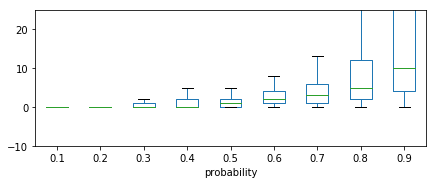

In [36]:
fig, ax = matplotlib.pyplot.subplots()

(
    df_model
    .drop(columns=['truth'])
    .plot.box(showfliers=False, ax=ax)
)

ax.set(
    xlabel='probability',

    ylim=(-10, 25)
)

In [37]:
(
    df_model
    .pipe(lambda d: d.apply(lambda s: s == 0)) 
    .mean()
)

0.1      0.942054
0.2      0.834497
0.3      0.688348
0.4      0.523822
0.5      0.369235
0.6      0.234770
0.7      0.133400
0.8      0.066532
0.9      0.030959
truth    0.434237
dtype: float64

In [38]:
df_model[lambda d: d['truth'] == 0].count() / len(df_model)

0.1      0.434237
0.2      0.434237
0.3      0.434237
0.4      0.434237
0.5      0.434237
0.6      0.434237
0.7      0.434237
0.8      0.434237
0.9      0.434237
truth    0.434237
dtype: float64

### Distribution of errors

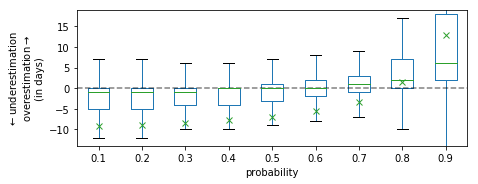

In [39]:
fig, ax = matplotlib.pyplot.subplots()

(
    df_model
    .pipe(lambda d: d.apply(lambda s: s - d['truth'])) 
    .drop(columns=['truth'])
    .plot.box(
        meanprops={'marker': 'x'},
        #medianprops=,
        showmeans=True,
        showfliers=False, 
        ax=ax
    )
)

ax.axhline(0, color='black', alpha=0.5, linestyle='dashed')

ax.set(
    xlabel='probability',
    ylabel='$\\leftarrow$underestimation\noverestimation$\\rightarrow$\n(in days)',
    ylim=(-14, 19)
)

ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=5))

savefig(fig, 'errors_distribution')

In [40]:
(
    df_model
    .pipe(lambda d: d.apply(lambda s: s - d['truth'])) 
    .drop(columns=['truth'])
    .describe()
)

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
count,214993.000000,214993.000000,214993.000000,214993.000000,214993.000000,214993.000000,214993.000000,214993.000000,214993.000000
mean,-9.112022,-8.935277,-8.474890,-7.828041,-6.990018,-5.665375,-3.431158,1.376952,12.859088
std,34.570061,34.497288,34.336856,34.157830,33.966464,33.746942,33.572626,34.184367,41.555437
min,-1702.000000,-1701.000000,-1701.000000,-1699.000000,-1698.000000,-1697.000000,-1694.000000,-1687.000000,-1676.000000
25%,-5.000000,-5.000000,-4.000000,-4.000000,-3.000000,-2.000000,-1.000000,0.000000,2.000000
50%,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,6.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,3.000000,7.000000,18.000000
max,14.000000,21.000000,29.000000,44.000000,62.000000,107.000000,178.000000,364.000000,676.000000


### Distribution of errors, w.r.t. over- and underestimations

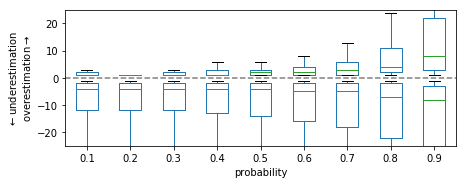

In [41]:
fig, ax = matplotlib.pyplot.subplots()

args = {
    'showfliers': False,
    'ax': ax
}

(
    df_model
    .pipe(lambda d: d.apply(lambda s: s - d['truth']))
    .clip(lower=0)
    .replace({0: pandas.np.nan})
    .drop(columns=['truth'])
    .plot.box(**args)
)

(
    df_model
    .pipe(lambda d: d.apply(lambda s: d['truth'] - s))
    .clip(lower=0)
    .replace({0: pandas.np.nan})
    .pipe(lambda d: -1 * d)
    .drop(columns=['truth'])
    .plot.box(**args)
)

ax.axhline(0, color='gray', linestyle='dashed')

ax.set(
    xlabel='probability',
    ylabel='$\\leftarrow$underestimation\noverestimation$\\rightarrow$',
    ylim=(-25, 25)
)

savefig(fig, 'errors_distribution_splitted')

## Identifying the "best" window size

So far we relied on a fixed window whose size if 'WINDOW_SIZE' (see constant in code).
In this part of the notebook, we will run and evaluate the model using different window sizes. A large window size will allow the model to rely on many more information to perform its prediction. A small window size will force the model to focus on the "very recent past". 

In [42]:
WINDOW_SIZES = [10, 20, 30, 50, 75, 100]

In [ ]:
df_results = dict()
df_window = dict()

In [43]:
# This cell is quite slow to run
for size in WINDOW_SIZES:
    df_window[size] = rolling_computation(df, window_size=size, probabilities=PROBABILITIES)
    df_results[size] = evaluate_rolling_model(df_window[size])

### Q-Q plots

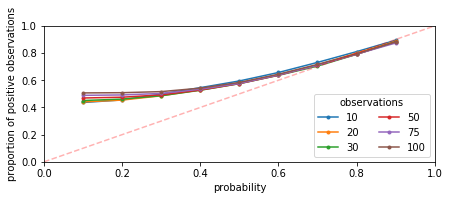

In [44]:
fig, ax = matplotlib.pyplot.subplots()

for size in WINDOW_SIZES:
    (
        df_results[size]
        .rename(columns={'upper': size})
        .plot(marker='.', legend=False, ax=ax)
    )
    
ax.legend(title='observations', ncol=2)

ax.set(
    xlim=(0, 1),
    xlabel='probability',
    ylim=(0, 1),
    ylabel='proportion of positive observations',
)

ax.plot([0, 1], [0, 1], linestyle='dashed', color='r', alpha=0.3)

savefig(fig, 'window_qqplot')

### Difference with perfect concordance

For each curve here above, we computed its difference with the "perfect concordance" line. 
We observe from the following (and previous) plot that higher window sizes lead to more overestimations for all probabilities (especially for lower ones).

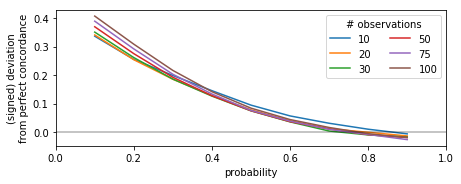

In [48]:
fig, ax = matplotlib.pyplot.subplots()

for size in WINDOW_SIZES:
    (
        df_results[size]
        .assign(error=lambda d: d['upper'] - d.index)
        .rename(columns={'error': size})
        [[size]]
        .plot(legend=False, ax=ax)
    )
    
ax.legend(title='# observations', ncol=2)

ax.set(
    xlim=(0, 1),
    xlabel='probability',
    #ylim=(-0.2, 1),
    ylabel='(signed) deviation\nfrom perfect concordance',
)

ax.plot([0, 1], [0, 0], color='k', alpha=0.3)

savefig(fig, 'window_qqplot_difference')

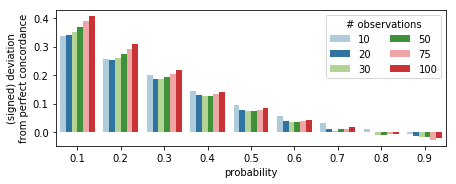

In [64]:
fig, ax = matplotlib.pyplot.subplots()
fig.set_size_inches(FIG_SIZE)

seaborn.barplot(
    x='probability',
    y='deviation', 
    hue='observations',
    hue_order=[str(s) for s in WINDOW_SIZES],
    data=(
        pandas.concat([
            df_results[size]
            .assign(**{str(size): lambda d: d['upper'] - d.index})
            [[str(size)]]
            for size in WINDOW_SIZES], axis=1
        ).reset_index(drop=False)
        .melt(id_vars='probability', var_name='observations', value_name='deviation')
    ),
    palette=seaborn.color_palette("Paired"),
    ax=ax,
)

ax.legend(ncol=2, title='# observations')
ax.set(
    ylabel='(signed) deviation\nfrom perfect concordance',
)

savefig(fig, 'window_qqplot_difference_bars')

### Sum of squared deviation from perfect concordance

Lower is better. 

In [46]:
for size in WINDOW_SIZES:
    error = (
        df_results[size]
        .assign(error=lambda d: ((d['upper'] - d.index)**2))
        ['error'].sum()
    )
    print(size, error)

10 0.25251967893936456
20 0.23992441226121386
30 0.2495006121788256
50 0.2734021294958607
75 0.30406795580601786
100 0.33762625941229973
